#Single Objective Rosenbrock Example
In this example you will learn how to set up a single objective differential evolution solver to solving for the minimum of the rosenbrock function. 

> Note: When working with an optimizer or with any code. It is important to know what folder you are launching the optimization on. You need to know where your working folder is. In Linux terminal or powershell you can type `pwd` to figure this out. 

> The paths that I use in the examples are all relative paths. This is so that the code is easily shared with others.

> Using absolute paths should only be reserved for programs that are sensitive and are not meant to be shared. 

## About Rosenbrock 
Rosenbrock is an interesting function with steep gradients near the bounds but as you get close to the minimum (blue zone) the gradients become less steep and close to 0. This makes it a hard function to find the minimum of.

The equation for Rosenbrock 

$f(x,y) = (a-x)^2 + b(y-x^2)^2$

Multi-variable version is 

$f(x) = f(x_1,x_2,x_3,...,x_n) = \sum_{i=1}^{N/2} [100(x_{2i-1}^2 - x_{2i})^2 + (x_{2i-1}-1)^2]$

Link to wikipedia article https://en.wikipedia.org/wiki/Rosenbrock_function 

[Example from Wikpedia](https://en.wikipedia.org/wiki/Rosenbrock_function#/media/File:Rosenbrock_function.svg)


## Methodology
1. This tutorial will cover the following steps cloning of the project. This downloads the code to evaluate the rosenbrock function. 
2. Is the setting up of glennopt to copy the evaluation function and execute a design of experiments(DOE). This evaluates the design space and lets the optimizer know where the minimum might be and what parameters. 
3. Optimization from the DOE. From the randomized design of experiments or non random if you use fullfactorial. The optimizer will proceed with taking the best design and perform mutation and crossover with other designs to generate a new population of potentially better designs. The loop will continue indefinitely; however it may reach something that is close to a minimum by the 50th population.


###Step 1: Cloning the Project and Rosenbrock codes
Lets clone the test project in Glennopt. We will need the test folder located in GlennOPT/test/Rosenbrock/serial/Evaluation/.

In [1]:
# Clone the source code for GlennOPT
!git clone https://github.com/nasa/GlennOPT.git
# Little Housekeeping
!cp -r GlennOPT/test/Rosenbrock/serial/Evaluation/ .    # Copy the folder we need 
!rm GlennOPT/ -r        # Deletes GlennOPT source code. We don't need this anymore
!rm sample_data -r

Cloning into 'GlennOPT'...
remote: Enumerating objects: 1391, done.
remote: Counting objects: 100% (722/722), done.
remote: Compressing objects: 100% (443/443), done.
remote: Total 1391 (delta 412), reused 521 (delta 246), pack-reused 669
Receiving objects: 100% (1391/1391), 2.75 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (791/791), done.


In [2]:
# Install GlennOPT 
!python --version
!pip install --upgrade glennopt pillow matplotlib numpy

Python 3.7.10
     |████████████████████████████████| 3.0MB 7.4MB/s 
     |████████████████████████████████| 10.3MB 44.2MB/s 
     |████████████████████████████████| 15.7MB 190kB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for diversipy: filename=diversipy-0.8-cp37-none-any.whl size=27531 sha256=88815252f698d124e9d0ffaddd6c9eb843610535d65f77863b3b75e79c2923bc
  Stored in directory: /root/.cache/pip/wheels/49/89/f4/1c64e470a0af08f4aefb99efec615e5da7907435b975ab64a6
  Created wheel for pydoe: filename=pyDOE-0.3.8-cp37-none-any.whl size=18184 sha256=96871d706961ae7ccb1e175632c6f6a33377f5bdb5fe9d4e322baa961d7352d0
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
  Created wheel for stringcase: filename=stringcase-1.2.0-cp37-none-any.whl size=3588 sha256=d8f914069ded44e731b08d318ac7e414afee68d330fa35242978c11e7e70733f
  Stored in directory: /root/.cache/pip/wheels/a0/16/a0/16e2c81dbd47503b5a35583dfabde5a9

Import relevant libraries

In [1]:
from glennopt.base import Parameter
from glennopt.optimizers import SODE
from glennopt.helpers import de_mutation_type, mutation_parameters, parallel_settings
from glennopt.DOE import Default,CCD,FullFactorial,LatinHyperCube
import os

In [2]:
# Setting up the optimizer
current_dir = os.getcwd()
pop_size = 20
sode = SODE(eval_command = "python evaluation.py", eval_folder="Evaluation",pop_size=pop_size,optimization_folder=current_dir)

# Selecting the DOE type
# doe = Default(15) # Default
# doe = CCD()
# doe = FullFactorial(levels=8)
doe = LatinHyperCube(128)

doe.add_parameter(name="x1",min_value=-3,max_value=3)
doe.add_parameter(name="x2",min_value=-3,max_value=3)
sode.add_eval_parameters(eval_params=doe.eval_parameters) # add in the parameters to sode 

doe.add_objectives(name='objective1')
sode.add_objectives(objectives=doe.objectives)  # add in the objectives into sode

# No performance Parameters
doe.add_perf_parameter(name='p1')
doe.add_perf_parameter(name='p2')
sode.add_performance_parameters(performance_params=doe.perf_parameters) # add performance parameters to sode

# params = mutation_parameters
sode.mutation_params.mutation_type = de_mutation_type.de_rand_1_bin
sode.mutation_params.F = 0.8
sode.mutation_params.C = 0.7

Enable Parallel Execution (OPTIONAL) 

In [3]:
# Parallel Settings (You don't need to run this block if you only want serial execution)
parallel_settings(concurrent_executions = 8,cores_per_execution = 1, execution_timeout=30) # 8 simulations at the same time, 1 core per simulation, 30 second timeout
sode.parallel_settings = parallel_settings # pass it into the SODE (Single Objective Differential Evolution)

##Run the Design of Experiments
Design of experiments is used to sample the evaluation space. Say you have 5 variables and f(x[1-5]) = y[1,2] and each x1 through x5 have min and max bounds. The design of experiments is used to evaluate different combinations of x1 to x5 which are used as the starting population (pop_start=-1) 

In [4]:
# Run the Design of Experiments
sode.start_doe(doe.generate_doe())  # This generates individuals that have evaluation parameters randomly distributed between the bounds 

100%|██████████| 128/128 [00:00<00:00, 13084.52it/s]

x1 had more than two levels. Assigning the end point to the high level.
x2 had more than two levels. Assigning the end point to the high level.


### Viewing the DOE Results in a Plot 

To view the results, we plot the rosenbrock function (Optional) and then the scattered points from the DOE evaluated. This shows where the optimizer is sampling the design space

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


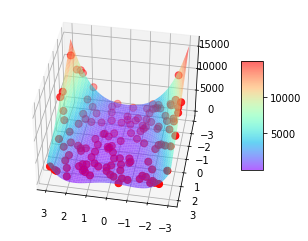

In [5]:
from Evaluation.rosenbrock import rosenbrock
import numpy as np

# Generate the Rosenbrock
xmin = -3; xmax = 3
ymin = -3; ymax = 3
x = np.linspace(xmin,xmax,50)
y = np.linspace(ymin,ymax,50)
X,Y = np.meshgrid(x,y)
Z = X*0
for i in range(50):
  for j in range(50):
    Z[i,j] = rosenbrock([X[i,j],Y[i,j]] )

# Read in the doe results
individuals = sode.read_calculation_folder()
eval_x = list(); eval_y = list(); eval_z = list()
for ind in individuals[0]:          # Read the DOE individuals
  eval_params = ind.eval_parameters
  eval_x.append(eval_params[0]); eval_y.append(eval_params[1])
  eval_z.append(ind.objectives[0])



# Plotting the function
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')
# Rosenbrock function 
surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
                       linewidth=0, alpha=0.6, antialiased=True)
# Plot the DOE's evaluation parameters (x,y) and objective value (z)
ax.scatter(eval_x,eval_y,eval_z,color="r",s=50)             

fig.colorbar(surf, shrink=0.5, aspect=5)
# rotate the axes and update
ax.view_init(40, 100)

##Run the Optimization

The code below executes the optimization. `-1` means we are starting from the DOE. If you wanted to start from a different population say population 5 just change `-1` to `5. The execution should take a few minutes.

In [6]:
# Execute the Optimization
sode.optimize_from_population(pop_start=-1,n_generations=50) # -1 means read the doe in and run the simulation

100%|██████████| 49/49 [01:52<00:00,  2.30s/it]


#Analyzing and Visualizing the Results

Plotting the best individuals and tracking that vs population. The code below shows how you can use get_best and get_pop_best to find the best individual vs population. 

**get_best** shows how the best performing individual changes as the population advances. 

**get_pop_best** looks at the individuals inside each population folder and finds the best one. 

Below is an example of get_best:

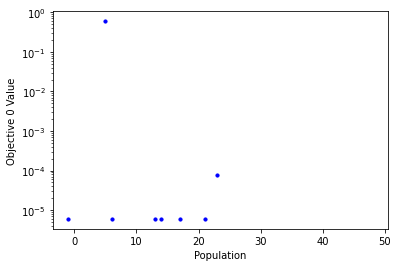

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from glennopt.helpers import get_best,get_pop_best

# Plotting get best
individuals = sode.read_calculation_folder()
objectives, pop, _ = get_best(individuals,pop_size=20)
objective_index = 0 # Single objective use 0, if you wanted the second or 3rd then just change to 1 and 2
_, ax = plt.subplots()    
ax.scatter(pop, objectives[:,objective_index],color='blue',s=10)
ax.set_xlabel('Population')
ax.set_ylabel('Objective {0} Value'.format(objective_index))
ax.set_yscale('log',base=10) 

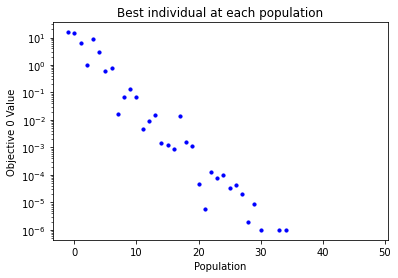

In [11]:
# Plot Best individual at each population
best_individuals, best_fronts = get_pop_best(individuals)

nobjectives = len(best_individuals[0][0].objectives)
objective_data = list()
for pop,best_individual in best_individuals.items():
    objective_data.append(best_individual[objective_index].objectives[objective_index])

_,ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(best_individuals.keys())))
ax.scatter(list(best_individuals.keys()), objective_data, color='blue',s=10)
ax.set_xlabel('Population')
ax.set_ylabel('Objective {0} Value'.format(objective_index))
ax.set_title('Best individual at each population')
ax.set_yscale('log',base=10) 


## Pareto Front

Because this is a single objective optimization. There really isn't a pareto front. 